# <span style="color:Maroon">Hurst Exponent based Segment Analysis

__Summary:__ <span style="color:Blue">Analysis to get thresholds for dividing data in windows based on hurst exponent

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(0)

In [2]:
# User defined names
index = "Gold"
filename = index+"_hurst.csv"
date_col = "Date"
hurst_windows = [100, 200, 300, 400] # Window sizes to calculate Hurst Exponent
N_days = 20 # Window size to do analysis for Hurst exponent

In [3]:
# Get current working directory
mycwd = os.getcwd()
print(mycwd)

C:\Users\sidhu\Downloads\Course 10 Capstone Project\Trading Strategy Development\Dev\Gold\Codes


In [4]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [5]:
# Read the data
df = pd.read_csv(filename, index_col=date_col)
df.index = pd.to_datetime(df.index)
df.head()

,High,Low,Open,Close,Volume,Adj Close,hurst_100,hurst_150,hurst_200,hurst_250,hurst_300,hurst_400
Date,,,,,,,,,,,,
2010-12-31,138.770004,137.720001,137.779999,138.720001,9219800,138.720001,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,139.000000,137.880005,138.669998,138.000000,11510200,138.000000,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,136.279999,134.160004,136.240005,134.750000,26154300,134.750000,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,134.679993,133.100006,133.500000,134.369995,16700900,134.369995,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,134.380005,133.139999,134.050003,133.830002,15965300,133.830002,NaN,NaN,NaN,NaN,NaN,NaN


## <span style="color:Maroon">Functions

In [6]:
def Calculate_Cols_onHurstwindow(df, window_size=100):
    """
    Calculates below metrics for different window sizes:
        Field 1: Number of days when the price went up compared to last day
        Field 2: Number of days when price went down compared to last day
        Field 3: Number of times the price went from Increasing to Decreasing
        Field 4: Number of times the price went from Decreasing to Increasing
        Field 5: Sum of number of times (price went from Increasing to Decreasing and price went from Decreasing to
        Increasing)
        Field 6: Ratio (Field 1/Field 2)
        Field 7: 1/Field 6
        Field 8: max(Field 6, Field 7)
        Field 9: Ratio (Field 3/Field 4)
        Field 10: 1/Field 9
        Field 11: max(Field 9, Field 10)
        Field 12: Field 9 - Field 9 mean
        Field 13: Field 11 - Field 11 mean
        Field 14: Field 12 * Field 13
    """
    df['Increasing days'] = df['Indicator Increasing'].rolling(window=window_size).sum()
    df['Decreasing days'] = df['Indicator Decreasing'].rolling(window=window_size).sum()
    df['Zero Cross Neg'] = df['Indicator Trend Pos to Neg'].rolling(window=window_size).sum()
    df['Zero Cross Pos'] = df['Indicator Trend Neg to Pos'].rolling(window=window_size).sum()
    df['Zero Cross Total'] = df['Zero Cross Neg'] + df['Zero Cross Pos']
    df['Ratio Trend tmp1'] = np.where(df['Decreasing days'] > 0, df['Increasing days']/df['Decreasing days'], 
                                     np.where(df['Increasing days'] > 0, 1, 0))
    df['Ratio Zero tmp1'] = np.where(df['Zero Cross Neg'] > 0, df['Zero Cross Pos']/df['Zero Cross Neg'], 
                                    np.where(df['Zero Cross Pos'] > 0, 1, 0))
    df['Ratio Trend tmp2'] = np.where(df['Ratio Trend tmp1'] > 0, 1/df['Ratio Trend tmp1'], 0)
    df['Ratio Zero tmp2'] = np.where(df['Ratio Zero tmp1'] > 0, 1/df['Ratio Zero tmp1'], 0)
    df['Ratio Trend'] = np.where(df['Ratio Trend tmp1'] > df['Ratio Trend tmp2'], df['Ratio Trend tmp1'], 
                                 df['Ratio Trend tmp2'])
    df['Ratio Zero'] = np.where(df['Ratio Zero tmp1'] > df['Ratio Zero tmp2'], df['Ratio Zero tmp1'],
                               df['Ratio Zero tmp2'])
    df.drop(['Ratio Zero tmp1', 'Ratio Zero tmp2', 'Ratio Zero tmp1', 'Ratio Zero tmp2'], axis=1, inplace=True)
    # Floor and cap ratios at 5
    df['Ratio Trend'] = np.where(df['Ratio Trend'] > 5, 5, df['Ratio Trend'])
    df['Ratio Zero'] = np.where(df['Ratio Zero'] > 5, 5, df['Ratio Zero'])
    
    df['Ratio Trend Normalized'] = df['Ratio Trend'] - df['Ratio Trend'].mean()
    df['Ratio Zero Normalized'] = df['Ratio Zero'] - df['Ratio Zero'].mean()
    df['Product Ratio'] = df['Ratio Trend Normalized'] * df['Ratio Zero Normalized']    
    return df

## <span style="color:Maroon">Calculations

In [7]:
# Calculate N days MA for Adjusted Close price variable
df['Adj Close MA20'] = df['Adj Close'].rolling(window=N_days).mean()

# Calculate first order difference between MA variable
df['Adj Close MA20 1diff'] = df['Adj Close MA20'].diff()

# Shift the first order difference by 1 day
df['Adj Close MA20 1diff 1shift'] = df['Adj Close MA20 1diff'].shift(1)

# Calculate the product of 1diff and 1diff 1 shift variable
df['Adj Close MA20 diff Product'] = df['Adj Close MA20 1diff'] * df['Adj Close MA20 1diff 1shift']

# Indicator to define if price is going up
df['Indicator Increasing'] = np.where(df['Adj Close MA20 1diff'] > 0, 1, 0)

# Indicator to define if price is going down
df['Indicator Decreasing'] = np.where(df['Adj Close MA20 1diff'] < 0, 1, 0)

# Indicator to define if Trend Shifted from Positive to Negative
df['Indicator Trend Pos to Neg'] = np.where(((df['Adj Close MA20 1diff'] < 0) & 
                                             (df['Adj Close MA20 1diff 1shift'] > 0)), 1, 0)

# Indicator to define if Trend Shifted from Negative to Positive
df['Indicator Trend Neg to Pos'] = np.where(((df['Adj Close MA20 1diff'] > 0) & 
                                             (df['Adj Close MA20 1diff 1shift'] < 0)), 1, 0)

## <span style="color:Maroon">Hurst Exponent Segment Analysis (Window size = 100)

In [8]:
# Change to Images directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [9]:
# Calculate the variables for window size = 100
window_size = 100
df = Calculate_Cols_onHurstwindow(df, window_size=window_size)

### <span style="color:Maroon"> Ratio of Number of days with Price Increase vs Price Decrease

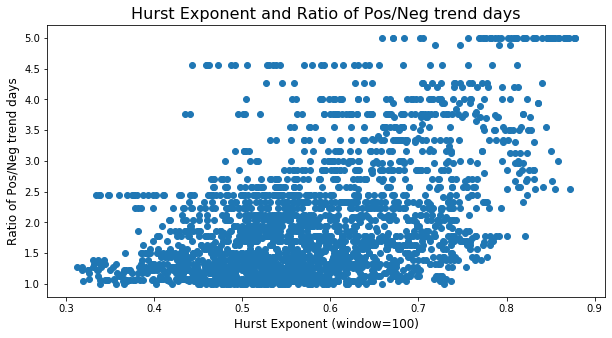

In [10]:
# Scatter plot to save fig
plt.figure(figsize=(10,5))
plt.scatter(df['hurst_'+str(window_size)], df['Ratio Trend'])
plt.xlabel("Hurst Exponent (window={})".format(window_size), fontsize=12)
plt.ylabel("Ratio of Pos/Neg trend days", fontsize=12)
plt.title("Hurst Exponent and Ratio of Pos/Neg trend days", fontsize=16)
plt.savefig("Hurst Exponent " + str(window_size)+ " and Ratio of PosNeg trend days " + str(index) +'.png')
plt.show()
plt.close()

__Comments:__ <span style="color:Blue"> As hurst exponent goes up the ratio of Trending days goes above 1

### <span style="color:Maroon"> Ratio of Number of zero crossovers (Pos to Neg and Neg to Pos)

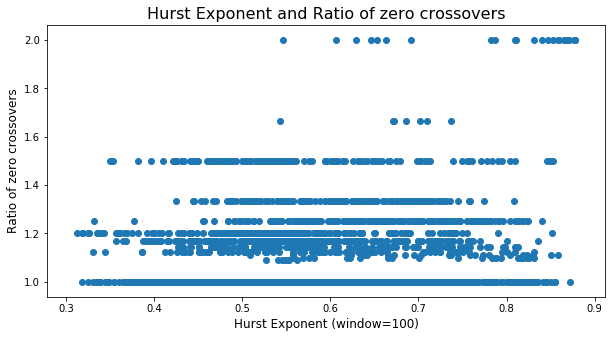

In [11]:
# Scatter plot to save fig
plt.figure(figsize=(10,5))
plt.scatter(df['hurst_'+str(window_size)], df['Ratio Zero'])
plt.xlabel("Hurst Exponent (window={})".format(window_size), fontsize=12)
plt.ylabel("Ratio of zero crossovers", fontsize=12)
plt.title("Hurst Exponent and Ratio of zero crossovers", fontsize=16)
plt.savefig("Hurst Exponent " + str(window_size)+ " and Ratio of zero crossovers " + str(index) +'.png')
plt.show()
plt.close()

__Comments:__ <span style="color:Blue"> There are few windows where we saw continous price increase (Hurst Exponent > 0.6)

### <span style="color:Maroon"> 3D Plot

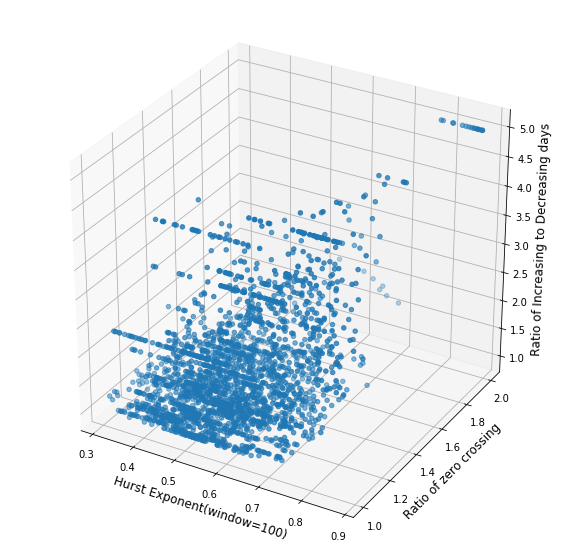

In [12]:
# Scatter plot to save fig
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xs=df['hurst_'+str(window_size)],ys= df['Ratio Zero'], zs=df['Ratio Trend'], zdir='z', s=20, c=None,
             depthshade=True)
ax.set_xlabel("Hurst Exponent(window={})".format(window_size), fontsize=12)
ax.set_ylabel("Ratio of zero crossing", fontsize=12)
ax.set_zlabel("Ratio of Increasing to Decreasing days", fontsize=12)
plt.savefig("Hurst Exponent " + str(window_size)+ " 3D Plot " + str(index) +'.png')
plt.show()
plt.close()

## <span style="color:Maroon">Hurst Exponent Segment Analysis (Window size = 200)

In [13]:
# Calculate the variables for window size = 200
window_size = 200
df = Calculate_Cols_onHurstwindow(df, window_size=window_size)

### <span style="color:Maroon"> Ratio of Number of days with Price Increase vs Price Decrease

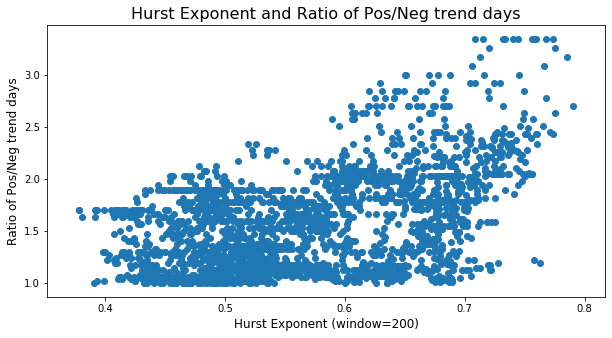

In [14]:
# Scatter plot to save fig
plt.figure(figsize=(10,5))
plt.scatter(df['hurst_'+str(window_size)], df['Ratio Trend'])
plt.xlabel("Hurst Exponent (window={})".format(window_size), fontsize=12)
plt.ylabel("Ratio of Pos/Neg trend days", fontsize=12)
plt.title("Hurst Exponent and Ratio of Pos/Neg trend days", fontsize=16)
plt.savefig("Hurst Exponent " + str(window_size)+ " and Ratio of PosNeg trend days " + str(index) +'.png')
plt.show()
plt.close()

__Comments:__ <span style="color:Blue">As hurst exponent goes up the ratio of Trending days goes above 1

### <span style="color:Maroon"> Ratio of Number of zero crossovers (Pos to Neg and Neg to Pos)

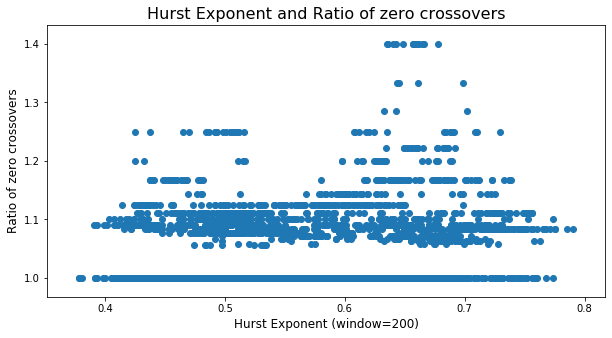

In [15]:
# Scatter plot to save fig
plt.figure(figsize=(10,5))
plt.scatter(df['hurst_'+str(window_size)], df['Ratio Zero'])
plt.xlabel("Hurst Exponent (window={})".format(window_size), fontsize=12)
plt.ylabel("Ratio of zero crossovers", fontsize=12)
plt.title("Hurst Exponent and Ratio of zero crossovers", fontsize=16)
plt.savefig("Hurst Exponent " + str(window_size)+ " and Ratio of zero crossovers " + str(index) +'.png')
plt.show()
plt.close()

### <span style="color:Maroon"> 3D Plot

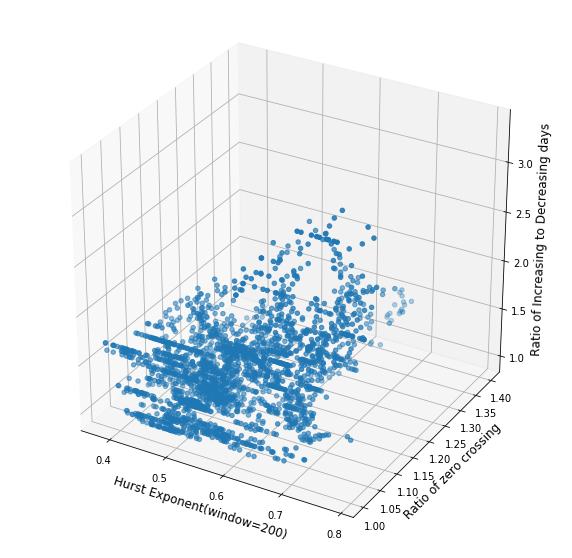

In [16]:
# Scatter plot to save fig
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xs=df['hurst_'+str(window_size)],ys= df['Ratio Zero'], zs=df['Ratio Trend'], zdir='z', s=20, c=None,
             depthshade=True)
ax.set_xlabel("Hurst Exponent(window={})".format(window_size), fontsize=12)
ax.set_ylabel("Ratio of zero crossing", fontsize=12)
ax.set_zlabel("Ratio of Increasing to Decreasing days", fontsize=12)
plt.savefig("Hurst Exponent " + str(window_size)+ " 3D Plot " + str(index) +'.png')
plt.show()
plt.close()

__Comments:__ <span style="color:Blue"> Based on above plots, Hurst exponent with window size=200 gives a better differenciation between segments

## <span style="color:Maroon">Segment Threshold Analysis

__Comments:__

$\;\;\;\;\;\;$ 1. <span style="color:Blue">Number of observations with hurst=0.5 are few
    
$\;\;\;\;\;\;$ 2. <span style="color:Blue">Based on the plots, we only see two clusters

In [17]:
# Get minimum and maximum value of hurst exponent
window_size_final = 200
min_val = round(df['hurst_'+str(window_size_final)].min(),2)
max_val = round(df['hurst_'+str(window_size_final)].max(),2)

In [18]:
# Range of cut offs 
hurst_cutoff = np.arange(min_val, max_val, 0.01).tolist()

# Initialize lists to store some results
Trend_gt150 = []
Zero_gt110 = []

In [19]:
def Get_hurst_Thresholdmetrics(df, hurst_window=100, hurst_threshold=0.5, trend_threshold=1.5, zero_threshold=1.1):
    """
    Using the hurst threshold to divide dataset, return below metrics:
    1. Ratio of Number of rows when Ratio Trend > trend_threshold in subset dataset to whole dataset
    2. Ratio of Number of rows when Ratio Zero > zero_threshold in subset dataset to whole dataset
    """
    df['Trend tmp high'] = np.where(df['Ratio Trend'] > trend_threshold, 1, 0)
    df['Zero tmp high'] = np.where(df['Ratio Zero'] > zero_threshold, 1, 0)
    rat_trend = df['Trend tmp high'][df['hurst_'+str(hurst_window)] > hurst_threshold].sum()/df['Trend tmp high'].sum()
    rat_zero = df['Zero tmp high'][df['hurst_'+str(hurst_window)] > hurst_threshold].sum()/df['Zero tmp high'].sum()
    return rat_trend, rat_zero

In [20]:
for i in range(0, len(hurst_cutoff)):
    rat_trend, rat_zero = Get_hurst_Thresholdmetrics(df, window_size_final, hurst_cutoff[i], 1.5, 1.1)
    Trend_gt150.append(rat_trend)
    Zero_gt110.append(rat_zero)

In [21]:
# Declare as numpy arrays
Trend_gt150 = np.array(Trend_gt150)
Zero_gt110 = np.array(Zero_gt110)

# Get 1 - above arrays values
Trend_gt150_neg = 1 - Trend_gt150
Zero_gt110_neg = 1 - Zero_gt110

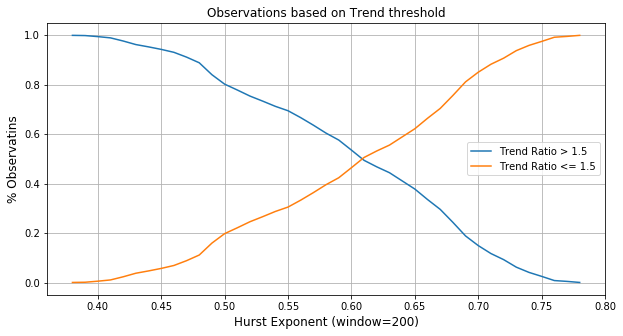

In [22]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(hurst_cutoff, Trend_gt150, label="Trend Ratio > 1.5")
plt.plot(hurst_cutoff, Trend_gt150_neg, label="Trend Ratio <= 1.5")
plt.xlabel("Hurst Exponent (window={})".format(window_size), fontsize=12)
plt.ylabel("% Observatins", fontsize=12)
plt.title('Observations based on Trend threshold')
plt.legend()
plt.grid()
plt.savefig('Trend threshold Segment'+ str(index) +'.png')
plt.show()
plt.close()

__Comments:__ <span style="color:Blue">Based on above plot, the data should be segmented in two segments (Hurst_200 <= 0.6 and Hurst_200 > 0.6)

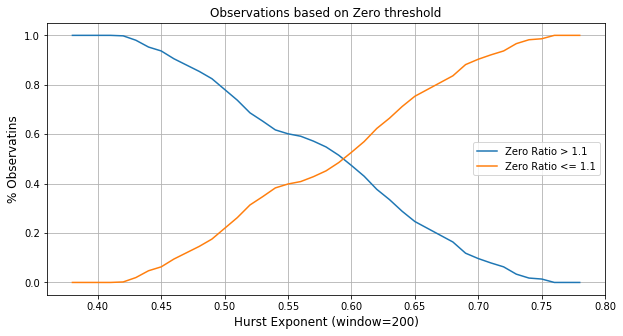

In [23]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(hurst_cutoff, Zero_gt110, label="Zero Ratio > 1.1")
plt.plot(hurst_cutoff, Zero_gt110_neg, label="Zero Ratio <= 1.1")
plt.xlabel("Hurst Exponent (window={})".format(window_size), fontsize=12)
plt.ylabel("% Observatins", fontsize=12)
plt.title('Observations based on Zero threshold')
plt.legend()
plt.grid()
plt.savefig('Zero threshold Segment' + str(index) +'.png')
plt.show()
plt.close()

__Comments:__ <span style="color:Blue">Based on above plot, the data should be segmented in two segments (Hurst_200 <= 0.6 and Hurst_200 > 0.6)

In [24]:
cut_off = ((hurst_cutoff[np.argmin(np.abs(Zero_gt110 - Zero_gt110_neg))]) + 
           (hurst_cutoff[np.argmin(np.abs(Trend_gt150 - Trend_gt150_neg))]) )/2
cut_off

0.6000000000000002

## <span style="color:Maroon">Save the Data

In [25]:
# Get the columns
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'hurst_100',
       'hurst_150', 'hurst_200', 'hurst_250', 'hurst_300', 'hurst_400',
       'Adj Close MA20', 'Adj Close MA20 1diff', 'Adj Close MA20 1diff 1shift',
       'Adj Close MA20 diff Product', 'Indicator Increasing',
       'Indicator Decreasing', 'Indicator Trend Pos to Neg',
       'Indicator Trend Neg to Pos', 'Increasing days', 'Decreasing days',
       'Zero Cross Neg', 'Zero Cross Pos', 'Zero Cross Total',
       'Ratio Trend tmp1', 'Ratio Trend tmp2', 'Ratio Trend', 'Ratio Zero',
       'Ratio Trend Normalized', 'Ratio Zero Normalized', 'Product Ratio',
       'Trend tmp high', 'Zero tmp high'],
      dtype='object')

In [26]:
# Drop columns which are not required and/or can't be used as Independent variables
df.drop(['Adj Close MA20 1diff 1shift', 'Ratio Trend tmp1', 'Ratio Trend tmp2', 'Ratio Trend Normalized',
         'Ratio Zero Normalized', 'Product Ratio', 'Trend tmp high', 'Zero tmp high'], 
        axis=1, inplace=True)

In [27]:
# Get the columns
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'hurst_100',
       'hurst_150', 'hurst_200', 'hurst_250', 'hurst_300', 'hurst_400',
       'Adj Close MA20', 'Adj Close MA20 1diff', 'Adj Close MA20 diff Product',
       'Indicator Increasing', 'Indicator Decreasing',
       'Indicator Trend Pos to Neg', 'Indicator Trend Neg to Pos',
       'Increasing days', 'Decreasing days', 'Zero Cross Neg',
       'Zero Cross Pos', 'Zero Cross Total', 'Ratio Trend', 'Ratio Zero'],
      dtype='object')

In [28]:
# Create segments
df['Segment'] = np.where(df['hurst_200'] > cut_off, "Trending", "Mean Reverting")

In [29]:
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")
df.to_csv(index +"_hurst_segment"+".csv", index=True)